In [1]:
import numpy as np
from analysis_pipeline import get_data
from analysis_pipeline import process_spikes as spk
from analysis_pipeline import make_plots

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import trange

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'

# to save figure images, if desired
# save_folder = base + 'Dynamic MEC Coding Project/fig2_images_final/'
# supp_save_folder = base + '/figure_folder/'

In [3]:
# define sessions
mice = ['Pisa', 'Hanover', 'Calais', # cue poor
        'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich (NP9 = male)
mouse_IDs = ['1c', '2a', '3a', '6a', '6b', '7a', '7b', '7c', '9a', ' 9b', '9c', '9d', '10a']
sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2'], # Hanover
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1'], # Seattle
            ['1005_2'],  # Portland
            ['1007_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
            ['1114_1', '1118_1'], # Vancouver
            ['1130_1', '1201_1', '1129_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 13
N sessions: 28


In [4]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : pink
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

session_colors = []
for m, session in zip(mice, sessions):
    for s in session:
        if m in ['Pisa', 'Hanover', 'Calais']:
            session_colors.append(cp_color)
        else:
            session_colors.append(cr_color)

In [5]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [6]:
# load the data
N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        Y, B, A, cells = get_data.open_files(f'{data_folder}gap_corrected/', 
                                             m, s)
        d['Y'] = Y
        d['B'] = B
        d['A'] = A
        d['cells'] = cells

        # count the total number of cells
        N_cells += d['cells'].shape[0]

Calais_0713_2 corrected for mistargeting
Toronto_1112_1 corrected for mistargeting
Mumbai_1130_1 corrected for mistargeting


In [7]:
# calculate trial-by-trial similarity
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        d['similarity'] = spk.similarity(Y)

In [8]:
''' fit k-means to get map labels for each trial '''
N = 2
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        d['kmeans'] = spk.fit_kmeans(Y, n_components=N, n_restarts=100)

In [9]:
# get map indices by observation and define map 0 as the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        d['idx'], d['map0_idx'] = spk.map_idx_by_obs(A, W)
        map_idx = np.row_stack((d['idx'].copy(), ~d['idx'].copy()))
        d['idx'] = map_idx

In [10]:
''' get X and y 
X : smoothed firing rate by timebin
y : position in radians
'''
dt = 0.02 # s
SMOOTHNESS = 10.0 # smooth FR with sigma = 200ms
REGULARIZATION = 1e-4

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A'].copy()
        B = d['B'].copy()
        
        # only calculate for >=400 spike cells
        keep_idx = np.where(np.sum(B, axis=0) >= 400)[0]
        B = B[:, keep_idx]
        
        # convert spikes to FR and smooth
        t_bin = dt
        X = B / t_bin # convert spike count to FR
        X = gaussian_filter1d(X, SMOOTHNESS, axis=0)
        
        # format position s.t. 0 = -pi = +pi = 400
        y_raw = A[:, 0]
        y = spk.cm_to_rad(y_raw)
        
        d['X'] = X
        d['y'] = y

In [11]:
''' downsample to match speed and num observations '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        speed = d['A'][:, 1]
        
        # get the indices for downsampling each map and all observations
        ds_0, ds_1, ds_all = spk.ds_to_match(map_idx=d['idx'].copy(), speed=speed)
        d['ds_idx'] = np.row_stack((ds_0, ds_1, ds_all))

In [12]:
''' fit model on each map with 10-fold cross-validation '''
for i in trange(len(mice)):
    m = mice[i]
    session = sessions[i]
    for s in session:
        d = data[m][s]
        X = d['X']
        y = d['y']
        ds_0 = d['ds_idx'][0, :]
        ds_1 = d['ds_idx'][1, :]
        ds_all = d['ds_idx'][-1, :]
        
        # get CV scores for each train and test combo - save these!
        model = spk.CircularRegression(alpha=REGULARIZATION)
        train0_test0_scores = spk.crossvalidate_blocks(model, X, y, ds_0, ds_0)
        
        model = spk.CircularRegression(alpha=REGULARIZATION)
        train0_test1_scores = spk.crossvalidate_blocks(model, X, y, ds_0, ds_1)
        
        model = spk.CircularRegression(alpha=REGULARIZATION)
        train1_test1_scores = spk.crossvalidate_blocks(model, X, y, ds_1, ds_1)
        
        model = spk.CircularRegression(alpha=REGULARIZATION)
        train1_test0_scores = spk.crossvalidate_blocks(model, X, y, ds_1, ds_0)
        
        model = spk.CircularRegression(alpha=REGULARIZATION)
        random_scores = spk.crossvalidate_blocks(model, X, y, ds_all, ds_all)
        
        d['scores'] = np.row_stack((train0_test0_scores, train0_test1_scores, 
                                    train1_test1_scores, train1_test0_scores, 
                                    random_scores))

 10%|██▉                          | 1/10 [00:01<00:11,  1.27s/it]


 20%|█████▊                       | 2/10 [00:00<00:00, 14.95it/s]


 90%|██████████████████████████   | 9/10 [00:05<00:00,  1.68it/s]


 10%|██▉                          | 1/10 [00:05<00:45,  5.07s/it]


 40%|███████████▌                 | 4/10 [00:06<00:10,  1.68s/it]


 70%|████████████████████▎        | 7/10 [00:09<00:04,  1.40s/it]


100%|████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]


 20%|█████▊                       | 2/10 [00:00<00:01,  5.63it/s]


 50%|██████████████▌              | 5/10 [00:04<00:04,  1.22it/s]


 80%|███████████████████████▏     | 8/10 [00:07<00:01,  1.11it/s]


  0%|                                     | 0/10 [00:00<?, ?it/s]


 30%|████████▋                    | 3/10 [00:04<00:10,  1.51s/it]


100%|███████████████████████████| 13/13 [39:34<00:00, 159.05s/it]


In [13]:
# across maps: shuffle by permuting the neuron labels and shifting the positions
N_REPEATS = 100
MAX_CELL_SHIFT = 10
MAX_POS_SHIFT = np.pi/2
for i in trange(len(mice)):
    m = mice[i]
    session = sessions[i]
    for s in session:
        d = data[m][s]
        shuff_file = data_folder + 'gap_corrected/' + m + '_' + s + '_across_map_decoder_shuff.npy'
        
        # check to see if the shuffle has already been computed
        if Path(shuff_file).exists():
            d['scores_across_shuffle'] = np.load(shuff_file)
            continue
        
        # if not, compute the shuffled scores
        X = d['X']
        y = d['y']
        train1_test0_scores, train0_test1_scores = spk.shuffle_scores(X, y, d['ds_idx'])
        d['scores_across_shuffle'] = np.stack((train1_test0_scores, train0_test1_scores), axis=-1)
        np.save(shuff_file, d['scores_across_shuffle'])

100%|████████████████████████████| 13/13 [00:00<00:00, 77.12it/s]


In [14]:
# get mean and 25/75th percentile for each session:
N_sessions = 0
for s in sessions:
    N_sessions += len(s)

avg_scores = np.zeros((N_sessions, 5))
pct_25 = np.zeros((N_sessions, 5))
pct_75 = np.zeros((N_sessions, 5))

i=-1
for m, session in zip(mice, sessions):
    for s in session:
        i+=1
        d = data[m][s]
        scores = d['scores']
        avg_scores[i, :] = np.mean(scores, axis=1)
        pct_25[i, :] = np.percentile(scores, 25, axis=1)
        pct_75[i, :] = np.percentile(scores, 75, axis=1)

In [15]:
'''
compute the performance for training/testing across maps
vs. shuffle (0%) and training/testing within map (100%)
'''

pct_best = np.zeros((N_sessions, 2))

# to count the sessions where the avg score is no better than chance
ns_01 = 0
ns_10 = 0

i = 0
for m, session in zip(mice, sessions):
    for s in session:
        # get the average scores for this session
        d = data[m][s]
        avg_0to0 = avg_scores[i, 0]
        avg_0to1 = avg_scores[i, 1]
        avg_1to1 = avg_scores[i, 2]
        avg_1to0 = avg_scores[i, 3]
        
        # get the shuffle scores for this session
        shuff_scores = d['scores_across_shuffle']
        
        # train map 0, test map 1
        train0_test1_shuff = shuff_scores[:, :, -1]
        shuff_thresh = np.percentile(train0_test1_shuff, 95)
        mean_shuff = np.mean(train0_test1_shuff)
        if avg_0to1 <= shuff_thresh:
            ns_01 += 1 # not significantly above chance
        pct_best_01 = (avg_0to1 - mean_shuff) / (avg_0to0 - mean_shuff)
        pct_best[i, 0] = pct_best_01
        
        # train map 1, test map 0
        train1_test0_scores = shuff_scores[:, :, 0]
        shuff_thresh = np.percentile(train1_test0_scores, 95)
        mean_shuff = np.mean(train1_test0_scores)
        if avg_1to0 <= shuff_thresh:
            ns_10 += 1 # not significantly above chance
        pct_best_10 = (avg_1to0 - mean_shuff) / (avg_1to1 - mean_shuff)
        pct_best[i, 1] = pct_best_10

        i += 1

In [16]:
print(f'train on map 0, test on map 1: {ns_01}/{N_sessions} sessions were not significantly better than chance')
print(f'train on map 1, test on map 0: {ns_10}/{N_sessions} sessions were not significantly better than chance')
print(f'performance on average {np.mean(pct_best):.2%} +/- {stats.sem(pct_best, axis=None):.2%} of best, relative to shuffle')

train on map 0, test on map 1: 1/28 sessions were not significantly better than chance
train on map 1, test on map 0: 2/28 sessions were not significantly better than chance
performance on average 68.31% +/- 3.73% of best, relative to shuffle


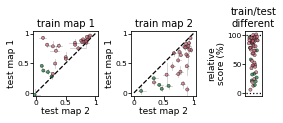

In [17]:
''' Figure 6E, F, G: within vs. across map model performance '''
f, gs = make_plots.plot_fig6efg(avg_scores, pct_75, pct_25, pct_best, session_colors)
# f.savefig(save_folder + 'compare_decoder_scores.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
''' for within map controls, compare the score on each map to the score on it's shuffled version '''
for i in trange(len(mice)):
    m = mice[i]
    session = sessions[i]
    for s in session:
        d = data[m][s]
        shuff_file = data_folder + 'gap_corrected/' + m + '_' + s + '_both_map_decoder_shuff.npy'
        
        # if the shuffle scores have been computed, use those
        if Path(shuff_file).exists():
            d['scores_shuffle_both'] = np.load(shuff_file)
            continue
        
        # otherwise, compute the shuffle scores
        X = d['X'].copy()
        y = d['y'].copy()
        both_scores_permute0, both_scores_permute1 = spk.shuffle_scores(X, y, d['idx'].copy(),
                                                                        N_REPEATS=100,
                                                                        MAX_CELL_SHIFT=20,
                                                                        MAX_POS_SHIFT=np.pi,
                                                                        same_map=True)
        d['scores_shuffle_both'] = np.stack((both_scores_permute0, both_scores_permute1), axis=-1)
        np.save(shuff_file, d['scores_shuffle_both'])

100%|████████████████████████████| 13/13 [00:00<00:00, 97.16it/s]


In [19]:
# get the average score for each session and the shuffle mean:
N_sessions = 0
for s in sessions:
    N_sessions += len(s)

avg_scores = np.zeros((N_sessions, 5))
avg_shuffle = np.zeros(N_sessions)

i=-1
for m, session in zip(mice, sessions):
    for s in session:
        i+=1
        d = data[m][s]
        scores = d['scores']
        avg_scores[i, :] = np.mean(scores, axis=1)
        
        shuff_scores = d['scores_shuffle_both']
        avg_shuffle[i] = np.mean(shuff_scores)

In [20]:
# compare the scores for each session to its corresponding shuffle
pct_decrease = np.zeros(N_sessions*2)
ns_1 = 0
ns_0 = 0
i = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        shuff_scores = d['scores_shuffle_both']
        avg_rand = avg_scores[i, -1]
        
        # permute 1
        permute1_scores = shuff_scores[:, :, -1]
        shuff_thresh = np.percentile(permute1_scores, 95)
        if avg_rand <= shuff_thresh:
            ns_1 += 1
        pct_decrease[i] = (np.mean(permute1_scores) - avg_rand) / avg_rand
        
        # permute 0
        permute0_scores = shuff_scores[:, :, 0]
        shuff_thresh = np.percentile(permute0_scores, 95)
        if avg_rand <= shuff_thresh:
            ns_0 += 1
        pct_decrease[i+N_sessions] = (np.mean(permute0_scores) - avg_rand) / avg_rand

        i += 1

In [21]:
print(f'train/test on both vs. map 0 + permuted 0: {ns_0}/{N_sessions} sessions were not significantly better than chance')
print(f'train/test on both vs. map 1 + permuted 1: {ns_1}/{N_sessions} sessions were not significantly better than chance')
print(f'avg percent decrease = {np.mean(pct_decrease):.2%}, SEM = {stats.sem(pct_decrease):.2%}')

train/test on both vs. map 0 + permuted 0: 0/28 sessions were not significantly better than chance
train/test on both vs. map 1 + permuted 1: 0/28 sessions were not significantly better than chance
avg percent decrease = -57.80%, SEM = 1.20%


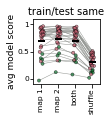

In [22]:
''' Figure 6D: performance for models trained/tested on the same map vs. shuffle '''
f, ax = make_plots.plot_fig6d(avg_scores, avg_shuffle, N_sessions, session_colors)
# f.savefig(save_folder + 'decoder_scores_sametosame_shuff.png', dpi=400, bbox_inches='tight')
plt.show()

In [28]:
avg_0to0 = avg_scores[:, 0]
avg_0to1 = avg_scores[:, 1]
avg_1to1 = avg_scores[:, 2]
avg_1to0 = avg_scores[:, 3]
avg_both = avg_scores[:, -1]

In [29]:
N_cue_poor_sessions = 0
for m, session in zip(mice, sessions):
    if m in ['Pisa', 'Hanover', 'Calais']:
        N_cue_poor_sessions += len(session)

# model scores for cue rich vs. poor sessions
avg_0to0 = avg_scores[:, 0]
avg_1to1 = avg_scores[:, 2]
cue_poor_Rs = np.append(np.append(avg_0to0[:N_cue_poor_sessions], 
                                  avg_1to1[:N_cue_poor_sessions]), avg_both[:N_cue_poor_sessions])
cue_rich_Rs = np.append(np.append(avg_0to0[N_cue_poor_sessions:], 
                                  avg_1to1[N_cue_poor_sessions:]), avg_both[N_cue_poor_sessions:])

In [31]:
# get mean and SEM for cue rich vs. poor sessions
print('mean, sem')
print(f'train 0, test 0: {np.mean(avg_0to0):.3}, {stats.sem(avg_0to0):.3}')
print(f'train 1, test 1: {np.mean(avg_1to1):.3}, {stats.sem(avg_1to1):.3}')
print(f'train both, test both: {np.mean(avg_both):.3}, {stats.sem(avg_both):.3}')

print(f'\ntrain 0, test 1: {np.mean(avg_0to1):.3}, {stats.sem(avg_0to1):.3}')
print(f'train 1, test 0: {np.mean(avg_1to0):.3}, {stats.sem(avg_1to0):.3}')

print(f'\ncue poor avg fit: {np.mean(cue_poor_Rs):.3}, {stats.sem(cue_poor_Rs):.3}')
print(f'cue rich avg fit: {np.mean(cue_rich_Rs):.3}, {stats.sem(cue_rich_Rs):.3}')

mean, sem
train 0, test 0: 0.703, 0.0483
train 1, test 1: 0.733, 0.0419
train both, test both: 0.693, 0.0448

train 0, test 1: 0.53, 0.0571
train 1, test 0: 0.493, 0.0539

cue poor avg fit: 0.324, 0.0416
cue rich avg fit: 0.793, 0.0182


In [33]:
# test for significance
# train/test map 0 vs. map 1 vs. both
m0vsm1_stat, m0vsm1_p = stats.kruskal(avg_0to0, avg_1to1, avg_both)
print(f'train/test map 0 vs. map 1 vs. both (Kruskal): p = {m0vsm1_p}')

# train/test same map vs. other map
same_to_same = np.append(avg_0to0, avg_1to1)
diff_to_diff = np.append(avg_0to1, avg_1to0)
sameVSdiff_stat, sameVSdiff_p= stats.wilcoxon(same_to_same, diff_to_diff)
print(f'\ntrain/test same vs. train/test different: p = {sameVSdiff_p}')
print(f'n = {same_to_same.shape[0]} model pairs')

# cue rich vs. poor
CRvsCP_stat, CRvsCP_p = stats.ranksums(cue_rich_Rs, cue_poor_Rs)
print(f'\ncue rich vs. poor: p = {CRvsCP_p}')

train/test map 0 vs. map 1 vs. both (Kruskal): p = 0.7693687743148763

train/test same vs. train/test different: p = 9.893602234325464e-11
n = 56 model pairs

cue rich vs. poor: p = 1.2440118386437162e-08
